In [2]:
import numpy as np
from tqdm import tqdm
import anndata as ad
import sys
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.io import savemat, loadmat
import os
import pandas as pd

In [3]:
data_folder = 'data/thomsonlab_signaling/'
large_data_folder = 'large_data/thomsonlab_signaling/'
fig_folder = 'figure/thomsonlab_signaling/'

In [4]:
cadata = ad.read_h5ad(large_data_folder + 'thomsonlab_signaling_filtered_2500_scvi_umap.h5ad')

/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [1]:
seed = 0
num_spin = 20
num_pool = num_spin
num_repeat = 10
task_name = "thomsonlab_signaling"
save_path = "./test/test_signalling/"

## Test with DSPIN Class

In [5]:
from util.dspin import DSPIN

In [34]:
# Reload the Package
from importlib import reload
import util.dspin  
reload(util.dspin)  
from util.dspin import DSPIN 

In [6]:
a = DSPIN(cadata, save_path, num_spin)

/Users/ygong/git/DSPIN-abstract/util/dspin.py:76: UserWarning: num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.
  warnings.warn("num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.")


100%|██████████| 24/24 [00:00<00:00, 59.13it/s]


Pre-computing
Round_1


Iteration Progress: 100%|██████████| 500/500 [01:59<00:00,  4.17it/s, Reconstruction Error=7127.64]


Round_2


Iteration Progress: 100%|██████████| 500/500 [02:11<00:00,  3.79it/s, Reconstruction Error=7640.20]


Round_3


Iteration Progress: 100%|██████████| 500/500 [02:24<00:00,  3.47it/s, Reconstruction Error=7642.77]


Round_4


Iteration Progress: 100%|██████████| 500/500 [02:23<00:00,  3.47it/s, Reconstruction Error=7667.71]


Round_5


Iteration Progress: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, Reconstruction Error=7679.47]


Round_6


Iteration Progress: 100%|██████████| 500/500 [02:40<00:00,  3.11it/s, Reconstruction Error=7686.10]


Round_7


Iteration Progress: 100%|██████████| 500/500 [02:32<00:00,  3.28it/s, Reconstruction Error=7676.25]


Round_8


Iteration Progress: 100%|██████████| 500/500 [02:21<00:00,  3.55it/s, Reconstruction Error=7676.85]


Round_9


Iteration Progress: 100%|██████████| 500/500 [02:11<00:00,  3.79it/s, Reconstruction Error=7679.04]


Round_10


Iteration Progress: 100%|██████████| 500/500 [02:21<00:00,  3.53it/s, Reconstruction Error=7686.29]
/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


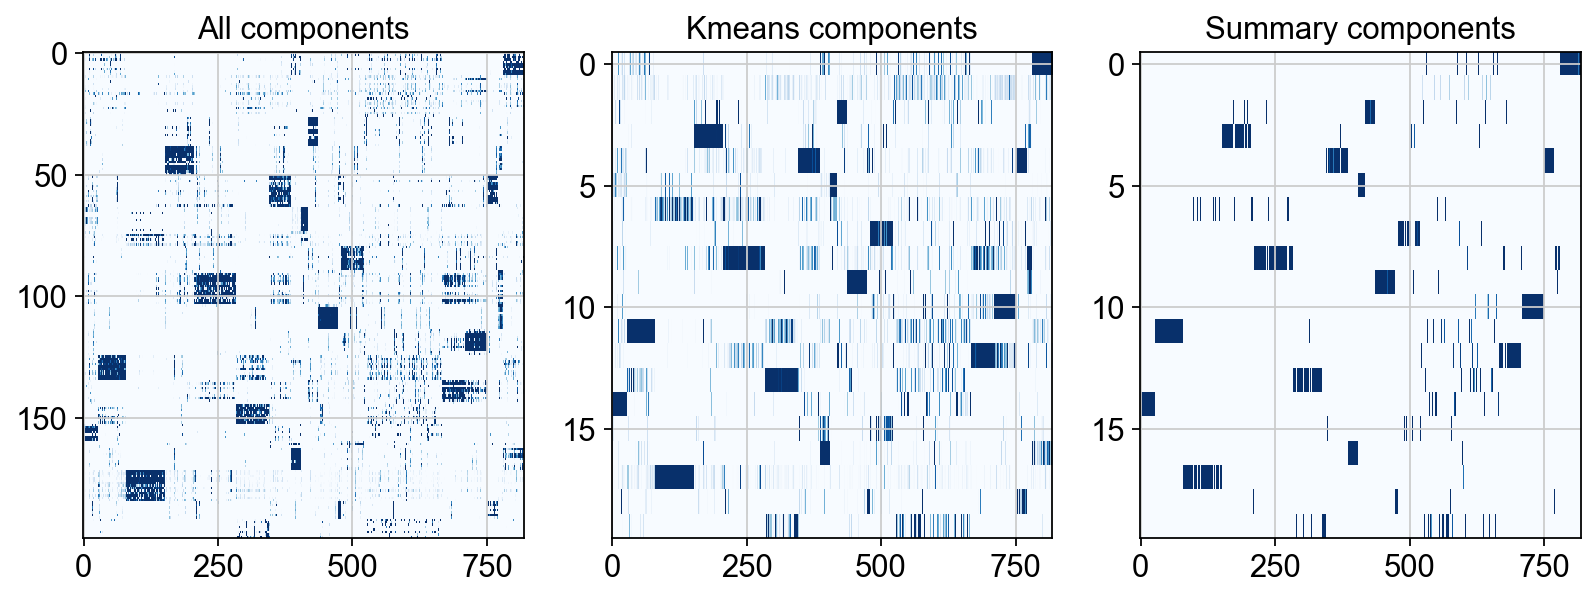

In [7]:
a.gene_program_discovery()

In [12]:
example_list = ['TNFA_200ng_mL_1-COVID-1', 'IL7_50ng_mL_1-COVID-1', 'LPS_50ng_mL_1-COVID-1', 'CCL2_200ng_mL_1-COVID-1', 'CONTROL_1-COVID-1']

100%|██████████| 20/20 [00:02<00:00,  6.94it/s]


Progress: 13, Network gradient: 17.579201
Progress: 20, Network gradient: 7.416781
Progress: 26, Network gradient: 3.751609
Progress: 33, Network gradient: 2.702838
Progress: 40, Network gradient: 2.246931
Progress: 46, Network gradient: 1.793304
Progress: 53, Network gradient: 1.679017
Progress: 60, Network gradient: 1.506811
Progress: 66, Network gradient: 1.040003
Progress: 73, Network gradient: 2.513596
Progress: 80, Network gradient: 0.788957
Halting due to three backtracks.


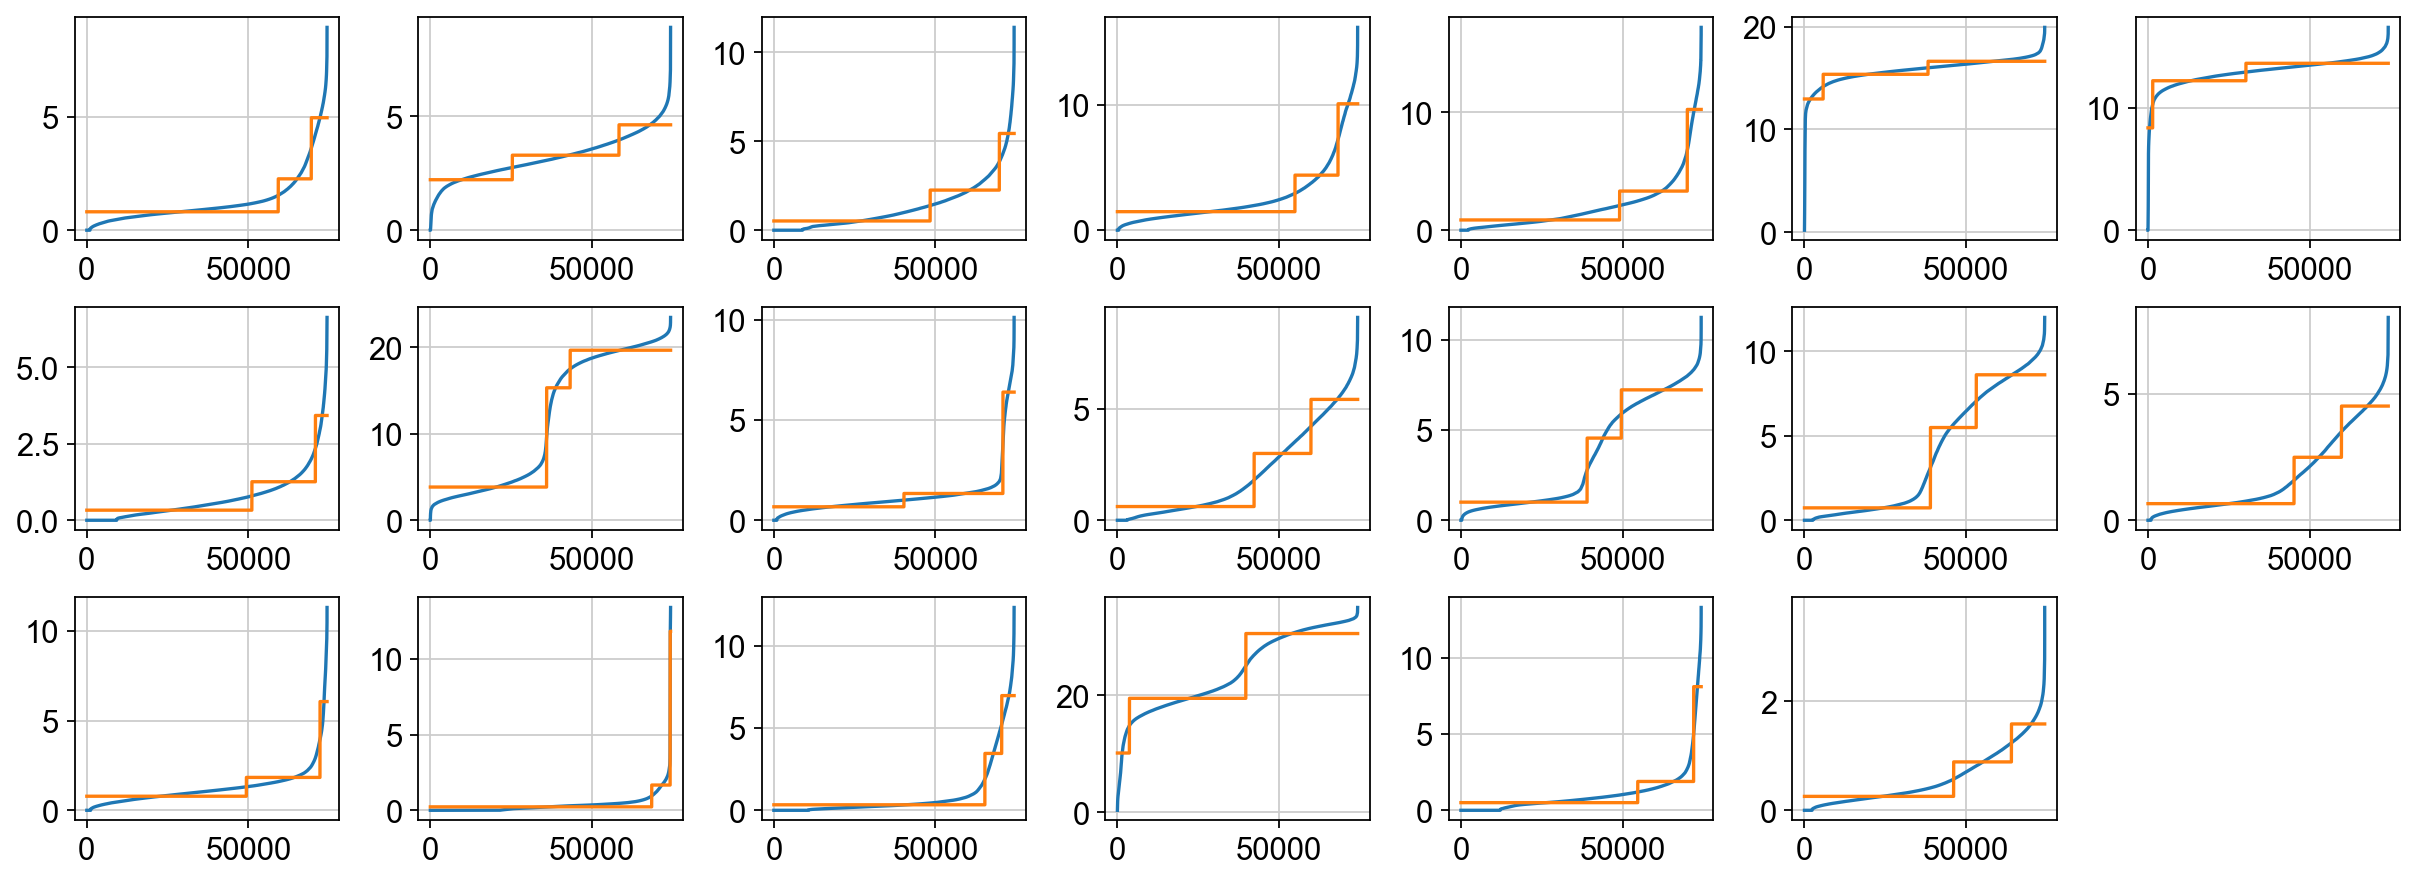

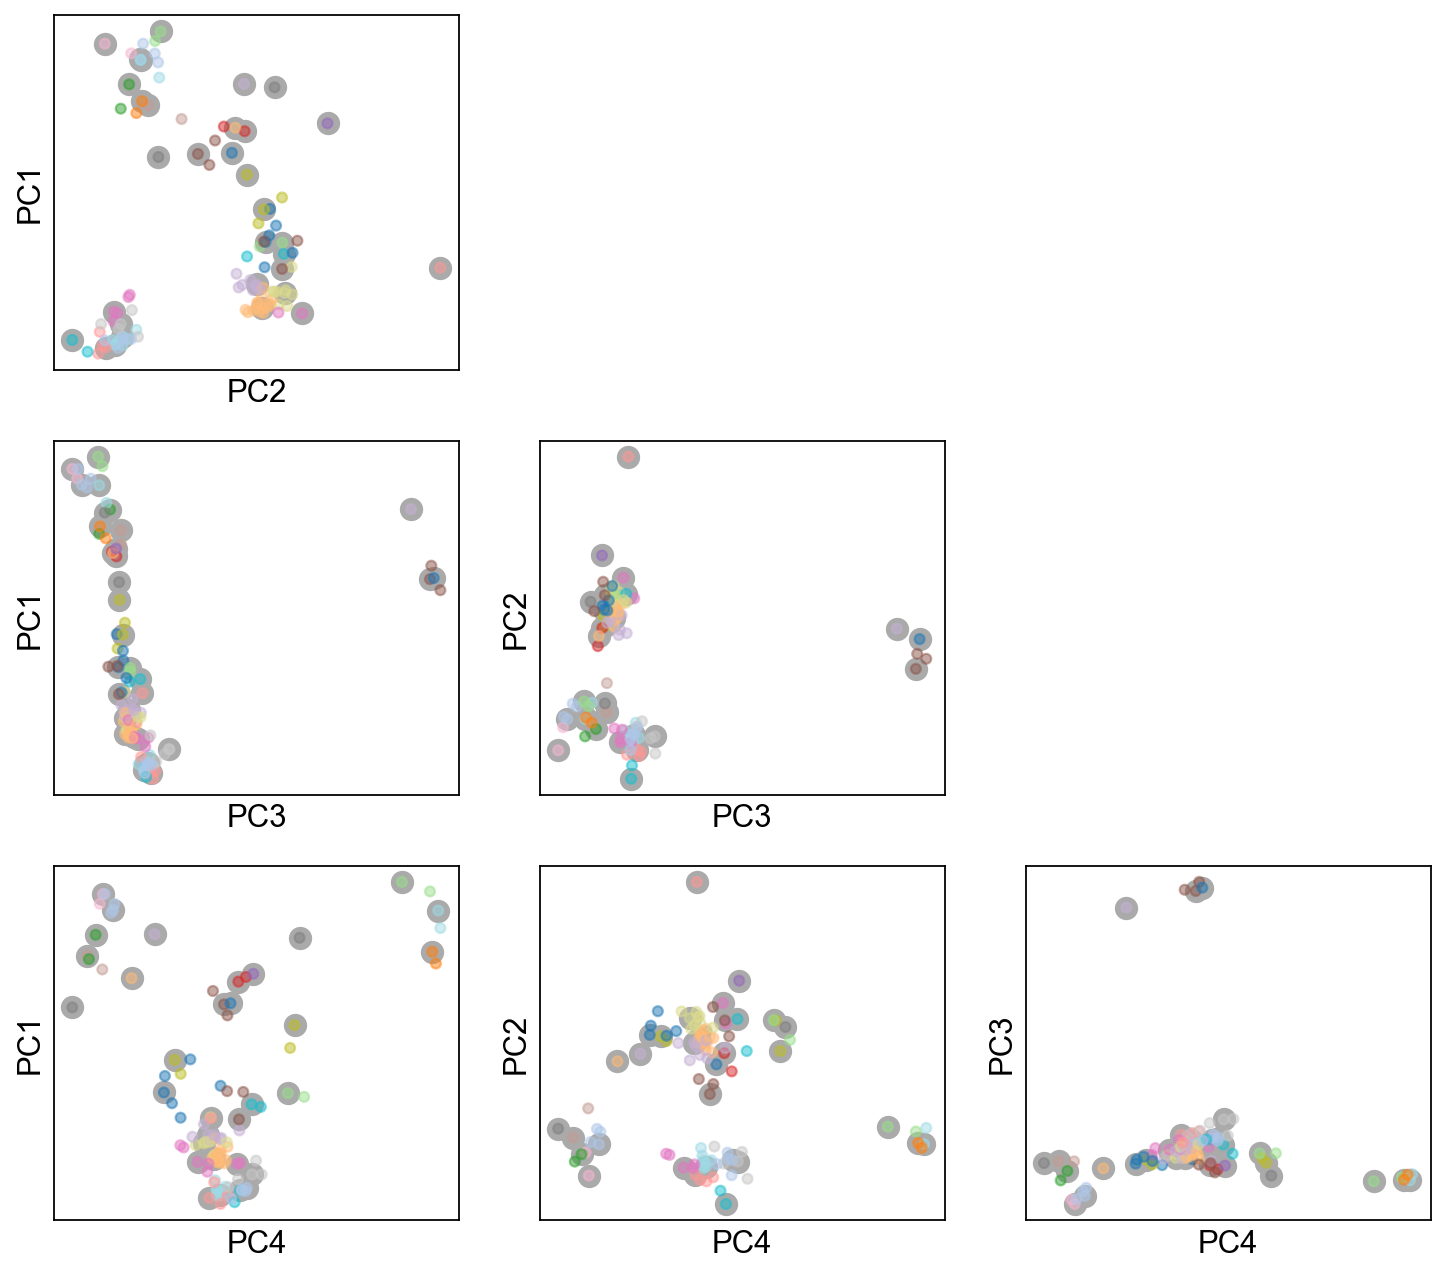

In [15]:
a.network_infer(sample_column_name='sample_batch', example_list=example_list)

### Directly Load onmf Summary

In [7]:
onmf_summary = np.load('test/test_signalling/onmf_summary_20.npy', allow_pickle=True).item()

In [8]:
a.onmf_summary = onmf_summary

In [9]:
a.matrix_balance()

### Verification the Correctness of ONMF Representation

In [ ]:
from util.plotting import onmf_gene_program_info

num_gene_show = 20
features = a.onmf_summary.components_
gene_name = cadata.var_names

onmf_gene_program_info(features, gene_name, num_gene_show, fig_folder)

#### Visualization of gene program decomposition

In [39]:
from importlib import reload
import util.compute
reload(util.compute)   

<module 'util.compute' from '/Users/ygong/git/DSPIN-abstract/util/compute.py'>

In [10]:
a.compute_onmf_rep_ori()

In [11]:
a.discretize()

100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


In [15]:
from util.plotting import temporary_spin_name

In [16]:
spin_name = temporary_spin_name('test/test_signalling/onmf_gene_list_20.csv')

In [17]:
fig_folder = '/Users/ygong/git/DSPIN-abstract/test/test_signalling/figs'

/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


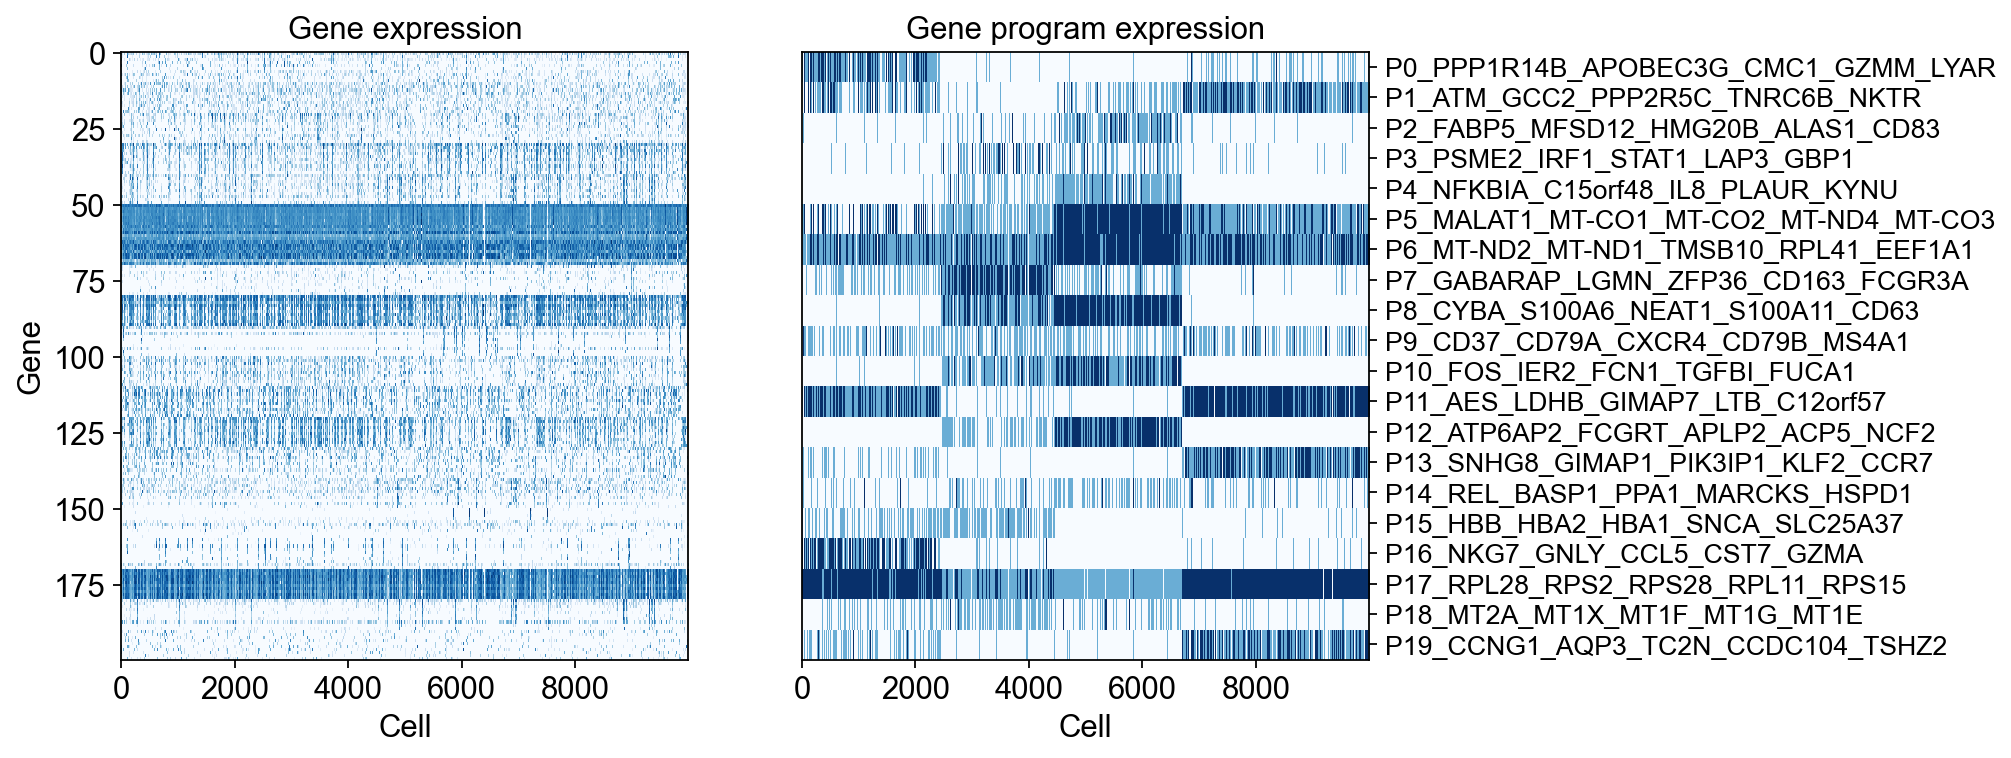

In [18]:
gene_program_decomposition(a.onmf_summary, num_spin, spin_name, a.gene_matrix_large, onmf_rep_tri, fig_folder)